Customer lifetime value (CLV, or CLTV) is a metric that gives an estimation of the total revenue a business can somewhat expect from a single customer.

We will predict Customer's Lifetime Value or expected number of purchases in the future(next couple of months/year) using Buy Till You Die model BG/NBD model. Which is also called Beta-Geometric Negative Binomial Distribution. 

We are also going to use the Gamma Gamma Model to predict the expected revenue in the future.

We are using Lifetimes library to calculate CLV. We have downloaded data from https://www.kaggle.com/code/shailaja4247/customer-lifetime-value-prediction/data.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lifetimes

import datetime as dt

from lifetimes import BetaGeoFitter # BG/NBD
from lifetimes import GammaGammaFitter # Gamma-Gamma Model
from lifetimes.plotting import plot_frequency_recency_matrix


In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df['Quantity'].min()

-80995

In [4]:
df['Quantity'].max()

80995

In [5]:
df.UnitPrice.min()

-11062.06

In [6]:
df = df[df['Quantity'] > 0 ] # exclude the purcheses with 0 or less items
df = df[df['UnitPrice'] > 0] # exclude the UnitPrice with 0 or less values

In [7]:
p=df['InvoiceNo']
print(list(p)[150:170])

[536382, 536382, 536382, 536384, 536384, 536384, 536384, 536384, 536384, 536384, 536384, 536384, 536384, 536384, 536384, 536384, 536385, 536385, 536385, 536385]


In [8]:
df['InvoiceNo'].str.contains("C",na=False).sum()

0

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):
# the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [12]:
capping_outliers(df,'UnitPrice')
capping_outliers(df,'Quantity')

In [13]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,8.868022,2.675785,15294.423453
std,9.523425,2.275053,1713.141560
min,1.000000,0.420000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,36.000000,8.500000,18287.000000


In [14]:
df['Total Price'] = df['UnitPrice'] * df['Quantity']

<AxesSubplot:xlabel='InvoiceDate'>

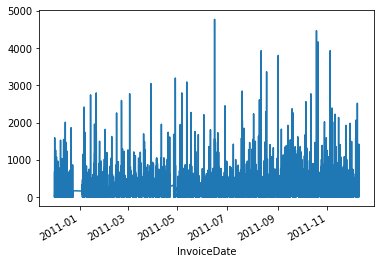

In [15]:
df.groupby(['InvoiceDate']).Quantity.sum().plot()

In [16]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Total Price',observation_period_end='2011-12-09')

In [17]:
clv

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,550.570000
12348.0,3.0,283.0,358.0,116.126667
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000
...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000
18281.0,0.0,0.0,180.0,0.000000
18282.0,1.0,119.0,126.0,69.340000


In [22]:
clv = clv[clv['frequency']>1] # we want only customers shopped more than 2 times

In [23]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1916 subjects, a: 0.00, alpha: 109.98, b: 0.00, r: 2.35>

In [25]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.352230e+00,9.460913e-02,2.166796e+00,2.537663e+00
alpha,1.099756e+02,4.886129e+00,1.003987e+02,1.195524e+02
a,7.059467e-17,2.175775e-11,-4.264513e-11,4.264527e-11
b,1.185773e-06,3.654458e-01,-7.162727e-01,7.162750e-01


In [37]:
#Expected Number of Purchases within 3 Months
t = 90 # 30 day month/period
clv['expected_purc_3_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_3_months',ascending=False).head(5)


,frequency,recency,T,monetary_value,expected_purc_3_months
CustomerID,,,,,
14911.0,131.0,372.0,373.0,917.278855,24.849499
12748.0,112.0,373.0,373.0,257.314911,21.308947
17841.0,111.0,372.0,373.0,349.079640,21.122603
15311.0,89.0,373.0,373.0,421.881573,17.023016
14606.0,88.0,372.0,373.0,125.302955,16.836671


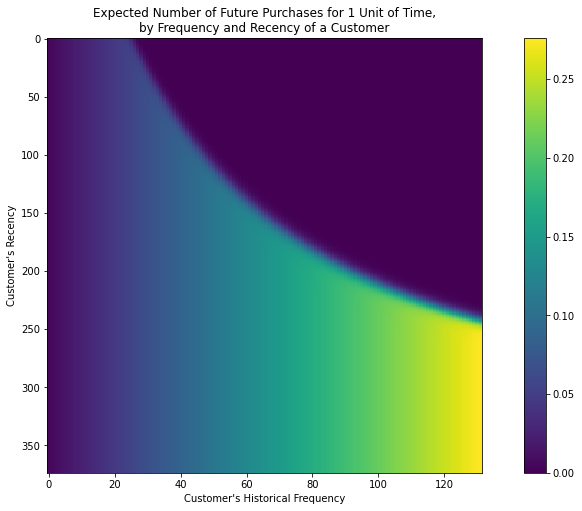

In [38]:
plt.figure(figsize=(15,8))
plot_frequency_recency_matrix(bgf)
plt.show()

Gamma-Gamma Model
After predicting the expected number of purchases of each customer. We need to use monetary value in order to predict CLV.

The Gamma Gamma model predicts the most likely value for each transaction.


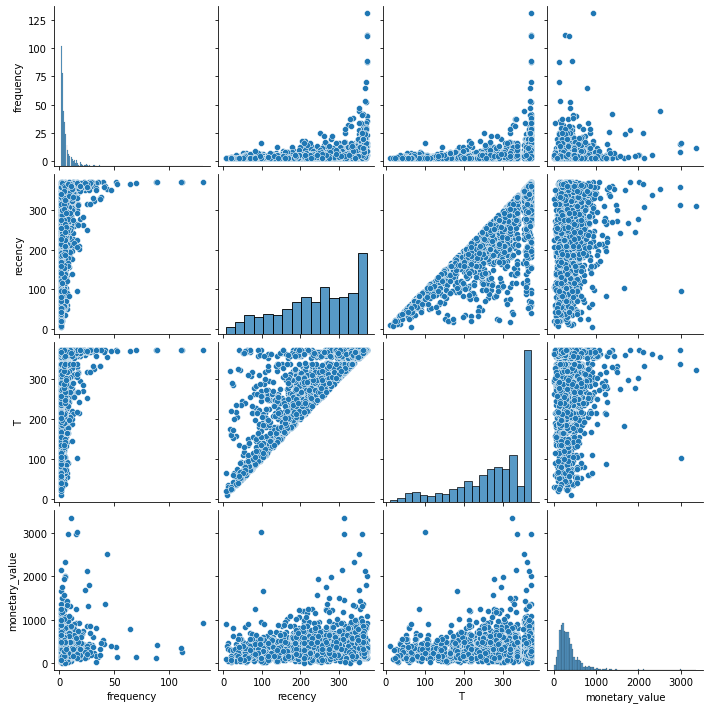

In [32]:
import seaborn as sns

sns.pairplot(clv)

In [33]:
#Assumptions for Gamma-Gamma Model- there should be no correlation between frequency and monetary value.
clv[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.110771
monetary_value,0.110771,1.000000


In [35]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"], clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1916 subjects, p: 3.79, q: 0.34, v: 3.72>

In [36]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.789079,0.118125,3.557555,4.020604
q,0.344041,0.008894,0.326610,0.361473
v,3.724072,0.118803,3.491218,3.956926


Predicting CLV for the Next 3 Months
Now, We are ready to predict Customer Lifetime Value using BG/NBD and Gamma Gamma Model.

In [39]:
clv['3_months_clv']=ggf.customer_lifetime_value(bgf, clv["frequency"],clv["recency"],clv["T"],
                                   clv["monetary_value"],time=3, freq='D', discount_rate=0.01)



In [42]:
clv.sort_values('3_months_clv').head(10)

,frequency,recency,T,monetary_value,expected_purc_3_months,3_months_clv
CustomerID,,,,,,
17816.0,3.0,329.0,365.0,6.783333,1.014159,8.466803
18037.0,5.0,208.0,362.0,7.654000,1.401981,11.957351
12891.0,2.0,107.0,292.0,15.120000,0.974439,17.759697
14609.0,3.0,224.0,296.0,15.120000,1.186526,20.196768
16308.0,3.0,224.0,261.0,15.120000,1.298470,22.102249
13848.0,2.0,274.0,366.0,39.420000,0.822943,36.460439
17736.0,2.0,104.0,113.0,19.250000,1.756698,39.803229
14500.0,2.0,101.0,189.0,27.500000,1.310143,41.285346
17988.0,4.0,315.0,326.0,31.332500,1.311314,43.351568


Segmenting CLV into Different Groups
We can also segment our customers into different groups.

In [44]:
clv['CustomerSegment'] =  pd.qcut(clv['3_months_clv'],4,labels = ['Hibernating','NeedAttention', 'LoyalCustomers', 'TopCustomers'])

In [45]:
clv

,frequency,recency,T,monetary_value,expected_purc_3_months,3_months_clv,CustomerSegment
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,550.570000,1.575973,876.874227,TopCustomers
12348.0,3.0,283.0,358.0,116.126667,1.029329,125.686624,Hibernating
12352.0,6.0,260.0,296.0,192.840000,1.851591,361.596640,NeedAttention
12356.0,2.0,303.0,325.0,226.080000,0.900512,220.295189,Hibernating
12359.0,3.0,274.0,331.0,1495.650000,1.092352,1701.132737,TopCustomers
...,...,...,...,...,...,...,...
18263.0,2.0,227.0,252.0,467.580000,1.082119,545.190368,LoyalCustomers
18272.0,5.0,244.0,246.0,485.688000,1.858837,918.204014,TopCustomers
18273.0,2.0,255.0,257.0,71.400000,1.067375,83.924215,Hibernating


In [47]:
clv.groupby(['CustomerSegment']).mean()

,frequency,recency,T,monetary_value,expected_purc_3_months,3_months_clv
CustomerSegment,,,,,,
Hibernating,3.169102,220.565762,291.824635,148.661593,1.276251,187.489547
NeedAttention,4.018789,239.442589,282.941545,270.869214,1.502015,387.477844
LoyalCustomers,5.682672,241.569937,273.110647,369.673664,1.917306,648.020197
TopCustomers,11.244259,264.486430,284.411273,636.264425,3.003776,1733.564181


<AxesSubplot:xlabel='CustomerSegment'>

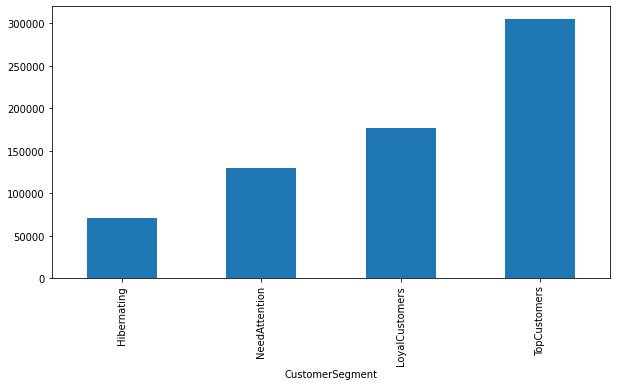

In [50]:
clv.groupby(['CustomerSegment']).monetary_value.sum().plot.bar(figsize=(10,5))